<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/RepVGG_test_1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GravCont: EfficientNet_b4_ImageNet**

In [3]:
from __future__ import print_function, division
!pip install torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、EfficientNetを用いて転移学習
－－－－－－－－－－－－－－
データの構造
gravcont.zip ------grav
               |---cont
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Random Seed:  1234
Mounted at /content/drive


#**set parameters**

In [4]:
path = '/content/drive/MyDrive/Deep_learning/666mai_dataset'
os.chdir(path)

# grav or cont, age, and sex
NUM_CLASSES = 3
# contains train, val
DATASET_PATH = r"./gravcont_250px_cross/"
TRAIN_FOLDER_NAME = "train"
VAL_FOLDER_NAME = "val"
EFFICIENT_NET_NAME = "RepVGG-A2-train"
MODEL_PATH = "./RepVGG-A2-train.pth"
#OPTIMIZER_PATH = "./optimizer_multi.pth"
SEX_DICT_PATH = "gender_json"
AGE_DICT_PATH = "age_json"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
BATCH_SIZE = 16

# transforms param
PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
TRAIN_CROP_SCALE =(0.75,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.2
TRAIN_CONTRAST_PARAM = 0.1
TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                transforms.RandomHorizontalFlip(),
                #transforms.ColorJitter(brightness=TRAIN_BRIGHTNESS_PARAM, contrast=TRAIN_CONTRAST_PARAM, saturation=TRAIN_SATURATION_PARAM, hue=TRAIN_HUE_PARAM),
                transforms.ToTensor(),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])])
val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])]) 

age_dict = []
with open(AGE_DICT_PATH, "r") as f:
        age_dict = json.load(f)
sex_dict = []
with open(SEX_DICT_PATH, "r") as f:
        sex_dict = json.load(f)  

#**Load and Batch the Data**

In [5]:
class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, age_dict, sex_dict, transform):
        self.transform = transform
        self.class_names = os.listdir(folder_path)
        self.item_paths = []
        self.item_dict = {}
        for class_num in range(len(self.class_names)):
                class_name = self.class_names[class_num]
                class_path = os.path.join(folder_path, class_name)
                for image_name in os.listdir(class_path):
                        base_name, ext = os.path.splitext(image_name)
                        if np.isnan(age_dict[base_name]):
                                continue
                        age = float(age_dict[base_name]) / 100
                        sex = float(sex_dict[base_name])
                        image_path = os.path.join(class_path, image_name)
                        self.item_paths.append(image_path)
                        self.item_dict[image_path] = (class_num, age, sex)

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        class_num, age, sex = self.item_dict[image_path]
        class_num = torch.tensor(class_num)
        age = torch.tensor(age)
        sex = torch.tensor(sex)
        variables = torch.tensor([age, sex])
        target= torch.tensor([class_num])

         
        return tensor_image, variables, target


train_dataset = SimpleImageDataset(os.path.join(DATASET_PATH, TRAIN_FOLDER_NAME), age_dict, sex_dict, train_data_transforms)
val_dataset = SimpleImageDataset(os.path.join(DATASET_PATH, VAL_FOLDER_NAME), age_dict, sex_dict, val_data_transforms)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

print(TRAIN_FOLDER_NAME + "_dataset_size：" + str(len(train_dataset)))


train_dataset_size：531


#**Test with early-stopping**

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss




def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (image_tensor, variables, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            target =target.squeeze_()

            image_tensor = image_tensor.to(device)
            variables = variables.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor, variables)
            # calculate the loss
            loss = loss_func(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for image_tensor, variables, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_func(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

#***evaluator（つかっていない）***

In [5]:
import os
import random
import numpy as np
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class Evaluator:
    def __init__(self, model, classes, age_dict, sex_dict, val_folder_path, val_transform, device, print_round_num=2) -> None:
        super().__init__()
        self.model = model
        self.val_folder_path = val_folder_path
        self.val_transform = val_transform
        self.device = device
        self.print_round_num = print_round_num
        
        self.class_names = classes
        self.age_dict = age_dict
        self.sex_dict = sex_dict
        self.image_paths = glob.glob(self.val_folder_path + "/*/*")
        print('eval number of classes: ' +str(len(self.class_names)))
        print('eval number of images: ' +str(len(self.image_paths)))
        random.shuffle(self.image_paths) 

        self.max_accuracy = 0
        # to update self.max_accuracy
        self.evaluate()
        print("initial accuracy: " + str(self.max_accuracy))

    def evaluate(self):
        TP = FP = TN = FN = TP = FP = TN = FN = 0
        image_name_list = []
        label_list = []
        model_pred_list = []

        model_pred_class = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label, age, sex = self.get_label(image_path)
            if np.isnan(age):
                    continue
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                
            output = output.squeeze(0)
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob = torch.clamp(output[0], 0, 1)
            pred = int(torch.round(prob))
            model_pred = self.class_names[pred]
            
            image_name_list.append(image_name)
            label_list.append(label)
            model_pred_list.append(model_pred)

            model_pred_class.append(int(pred))
            model_pred_prob.append(float(prob))

            if label == self.class_names[0]:
                if model_pred == self.class_names[0]:
                    TN += 1
                else:
                    FP += 1
            elif label == self.class_names[1]:
                if model_pred == self.class_names[1]:
                    TP += 1
                else:
                    FN += 1

        accuracy, precision, recall, specificity, f_value = self.calculate_accuracy(TP, TN, FP, FN)
        is_best = self.max_accuracy < accuracy
        if is_best:
            self.max_accuracy = accuracy

        return is_best, (round(accuracy, self.print_round_num), 
            round(precision, self.print_round_num), 
            round(recall, self.print_round_num), 
            round(specificity, self.print_round_num), 
            round(f_value, self.print_round_num))
        
    def draw_roc(self, output_path):
        label_list = []
        model_pred_prob = []

        for image_path in self.image_paths:
            image_name, label, age, sex = self.get_label(image_path)
            image_tensor = self.get_image_tensor(image_path)

            is_training = self.model.training
            self.model.eval()
            with torch.no_grad():
                output = self.model(image_tensor)
            if is_training:
                self.model.train()
                
            output = output.squeeze(0)
            #model_pred:クラス名前、prob:確率、pred:クラス番号
            prob = torch.clamp(output[0], 0, 1)

            label_list.append(label)
            model_pred_prob.append(float(prob))

        y_score = []
        y_true = []

        k=0
        for i in label_list:
            if label_list[k] == 'cont':
                y_true.append(0)
            elif label_list[k] == 'grav':
                y_true.append(1)
            k+=1

        #健康な状態を「0」、病気を「1」としてラベルよりリストを作成
        y_true = y_true
        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob
        try:
            fpr, tpr, thred = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic example')
            plt.legend(loc="lower right")
            plt.savefig(output_path)
        except:
            pass

    #対象のパスからラベルを抜き出す
    def get_label(self, image_path):
        image_name = os.path.basename(image_path)
        
        base_name, ext = os.path.splitext(image_name)
        age = float(self.age_dict[base_name]) / 100
        sex = float(self.sex_dict[base_name])
        
        label = os.path.basename(os.path.dirname(image_path))
        return(image_name, label, age, sex)
        
    def get_image_tensor(self, image_path):    
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.val_transform(image)
        image_tensor.unsqueeze_(0)
        image_tensor = image_tensor.to(self.device) 
        return(image_tensor)
        
    def calculate_accuracy(self, TP, TN, FP, FN):
        try:
            accuracy = (TP + TN)/ (TP + TN + FP + FN)
            precision  = TP/(FP + TP)
            recall = TP/(TP + FN)
            specificity = TN/(FP + TN)
            f_value = (2*recall*precision)/(recall+precision)
        except:
            accuracy = -1
            precision  = -1
            recall = -1
            specificity = -1
            f_value = -1
        return(accuracy, precision, recall, specificity, f_value)


#**define RepVGG-A2**

In [8]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_features=1408+2, out_features=2) #全結合層に年と性別を加える

    def forward(self, x, variables):
        x = self.repVGG(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = torch.cat([x, variables], dim=1)
        x = self.fc(x)
        return x

#**ConvNetの調整**

In [9]:
model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load(MODEL_PATH)) 
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.CrossEntropyLoss()

#Optimizer
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

#**def main()**

In [10]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, patience, EPOCH, device)

ストリーミング出力は最後の 5000 行に切り捨てられました。
          [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]]],


        ...,


        [[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, 

KeyboardInterrupt: ignored

#**訓練と評価**

In [10]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=15, num_epochs=2)


Epoch 0/1
----------


TypeError: ignored

#**Calculate Accuracy**
・True positive (TN)<br>
・False positive (FP)<br>
・True negative (TN)<br>
・False negative (FN)<br>

Accuracy = (TP + TN)/ (TP + TN + FP + FN)<br>
Precision = TP/(FP + TP) ※positive predictive value<br>
Recall = TP/(TP + FN)　※sensitivity<br>
Specificity = TN/(FP + TN)<br>
F_value = (2RecallPrecision)/(Recall+Precision)<br>

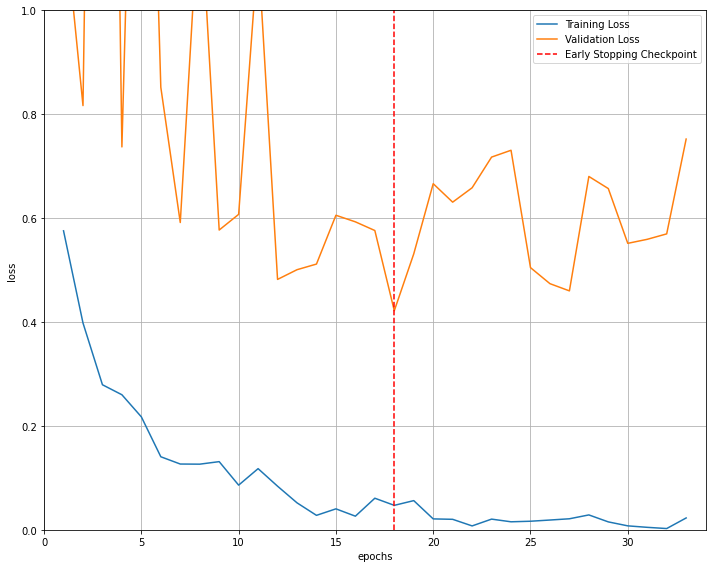

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

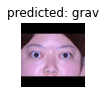

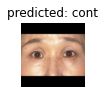

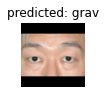

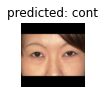

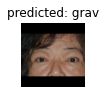

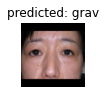

In [ ]:
visualize_model(model_ft)

In [ ]:
#評価モードにする
model_ft.eval()

#valフォルダ内のファイル名を取得
image_path = glob.glob(data_dir + "/val/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print('number of images: ' +str(len(image_path)))
#print(image_path) 



"""
#ファイル名よりラベルを抜き出し、'class_name'と定義
class_name = []
class_path = glob.glob('/content/drive/My Drive/Deep_learning/applstra/val/*')
for i in class_path:
    class_name.append(os.path.basename(i))  
print(class_name)
"""

#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #model_pred:クラス名前、prob:確率、pred:クラス番号
    prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
    model_pred = class_names[pred]
    
    #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
    prob = abs(1-float(prob)-float(pred))
 
    return model_pred, prob, pred

    """
    #probalilityを計算する
    pred_prob = torch.topk(nn.Softmax(dim=1)(output), 1)[0]
    pred_class = torch.topk(nn.Softmax(dim=1)(output), 1)[1]
    if pred_class == 1:
        pred_prob = pred_prob
    elif pred_class == 0:
        pred_prob = 1- pred_prob
    return(model_pred, pred_prob)  #class_nameの番号で出力される
    """

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    return(accuracy, precision, recall, specificity, f_value)


#ここからがメイン
TP, FP, TN, FN, TP, FP, TN, FN = [0,0,0,0,0,0,0,0]
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []

model_pred_class = []
model_pred_prob = []


for i in image_path:
      image_name, label = getlabel(i)  #画像の名前とラベルを取得
      image_tensor = image_transform(i)  #予測のための画像下処理
      model_pred, prob, pred = image_eval(image_tensor, label)  #予測結果を出力   
      #print('Image: '+ image_name)
      #print('Label: '+ label)
      #print('Pred: '+ model_pred)
      #showImage(i)  #画像を表示
      #print() #空白行を入れる
      time.sleep(0.1)

      image_name_list.append(image_name)
      label_list.append(label)
      model_pred_list.append(model_pred)

      model_pred_class.append(int(pred))
      model_pred_prob.append(float(prob))

      if label == class_names[0]:
          if model_pred == class_names[0]:
              TN += 1
          else:
              FP += 1
      elif label == class_names[1]:
          if model_pred == class_names[1]:
              TP += 1
          else:
              FN += 1
      

print(TP, FN, TN, FP)

#Accuracyを計算
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP, TN, FP, FN)
print('Accuracy: ' + str(accuracy))
print('Precision (positive predictive value): ' + str(precision))
print('Recall (sensitivity): ' + str(recall))
print('Specificity: ' + str(specificity))
print('F_value: ' + str(f_value))

print(model_pred_class)
print(model_pred_prob)

number of images: 134
59 8 61 6
Accuracy: 0.8955223880597015
Precision (positive predictive value): 0.9076923076923077
Recall (sensitivity): 0.8805970149253731
Specificity: 0.9104477611940298
F_value: 0.8939393939393939
[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
[0.9561910629272461, 0.9893732666969299, 0.9967695474624634, 0.011681437492370605, 0.9999785423278809, 0.9977245926856995, 2.384185791015625e-06, 0.9992450475692749, 0.10808610916137695, 0.3920801877975464, 0.9998989105224609, 0.02275913953781128, 3.0994415283203125e-06, 0.12613123655319214, 1.0, 2.5033950805664062e-06, 8.106231689453125e-06, 0.999977707862854, 0.99985444545

#**Drawing ROC curve**

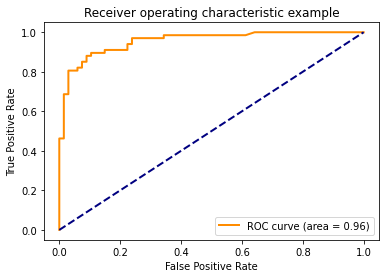

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = []
y_true = []

k=0
for i in label_list:
    if label_list[k] == 'cont':
          y_true.append(0)
    elif label_list[k] == 'grav':
          y_true.append(1)
    k+=1


#健康な状態を「0」、病気を「1」としてラベルよりリストを作成
y_true = y_true
#それぞれの画像における陽性の確率についてリストを作成
y_score = model_pred_prob

#print(y_true)
#print(y_score)

fpr, tpr,thred = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

#print(fpr)
#print(tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


#**ネットワークの保存と読み込み**

In [ ]:
#ネットワークの保存
PATH = '/content/drive/My Drive/Deep_learning/GravCont_EfficientNet-b4_ImageNet_seed'+str(manualSeed)+'.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
#ネットワークの読み込み
PATH = '/content/drive/My Drive/Deep_learning/GravCont_EfficientNet-b4_ImageNet_seed'+str(manualSeed)+'.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>